In [1]:
!nvidia-smi

Fri Jul 16 20:08:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
if os.path.exists("ml-lib"):
  os.system("rm -rf ml-lib")

!git clone https://github.com/mln00b/ml-lib.git

Cloning into 'ml-lib'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 165 (delta 70), reused 132 (delta 41), pack-reused 0
Receiving objects: 100% (165/165), 21.98 KiB | 10.99 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [3]:
import os, sys
sys.path.insert(0, "ml-lib")


In [4]:
!pip install -q albumentations==1.0.0
!pip install -q torchsummary

     |████████████████████████████████| 102kB 7.5MB/s 
     |████████████████████████████████| 37.2MB 134kB/s 


In [5]:
from mllib.models.resnet import ResNet18
from mllib.datasets.tinyimagenet import get_train_test_transform_options, get_train_test_dataloaders
from mllib.utils.transform import get_transforms
from mllib.train import train_and_test_classification
from mllib.utils.plot import plot_single_run
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np

In [6]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchsummary import summary

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
np.random.seed(42)
torch.manual_seed(42)
if use_cuda:
  torch.cuda.manual_seed(42)


In [8]:
NUM_CLASSES = 200

In [9]:
model =  ResNet18(num_classes=NUM_CLASSES).to(device)
print(summary(model, (3,64,64)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [10]:
train_transform_options, test_transform_options = get_train_test_transform_options()
print("train_transform_options: ", train_transform_options)
print("test_transform_options: ", test_transform_options)

train_transform_options:  [{'ty': 'Pad', 'config': {'min_height': 72, 'min_width': 72, 'always_apply': True}}, {'ty': 'RandomCrop', 'config': {'height': 64, 'width': 64, 'p': 1}}, {'ty': 'HorizontalFlip', 'config': {'p': 0.5}}, {'ty': 'CoarseDropout', 'config': {'max_holes': 1, 'min_holes': 1, 'max_height': 32, 'max_width': 32, 'p': 0.5, 'fill_value': (122.51178945, 114.2915559, 101.3880867), 'min_height': 32, 'min_width': 32}}, {'ty': 'Normalize', 'config': {'mean': [0.48043839, 0.44820218, 0.39760034], 'std': [0.27698959, 0.26908774, 0.28216029], 'always_apply': True}}]
test_transform_options:  [{'ty': 'Normalize', 'config': {'mean': [0.48043839, 0.44820218, 0.39760034], 'std': [0.27698959, 0.26908774, 0.28216029], 'always_apply': True}}]


In [11]:
train_transforms = get_transforms(train_transform_options)
test_transforms = get_transforms(test_transform_options)

In [12]:
train_loader, test_loader = get_train_test_dataloaders(
    train_bs=512, test_bs=128, 
    train_transforms = train_transforms, test_transforms = test_transforms, 
    use_cuda=use_cuda)
print(len(train_loader), len(test_loader))

196 79


In [13]:
EPOCHS = 10
LR = 1.0
MOMENTUM = 0.9
WD = 0

loss_fn = F.cross_entropy
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WD)

In [14]:
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WD)

In [15]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LR, 
    steps_per_epoch=len(train_loader), 
    epochs=EPOCHS,
    anneal_strategy='linear')

In [16]:
train_losses, test_losses, train_acc, test_acc = train_and_test_classification(
    model=model, device=device, 
    train_loader=train_loader, test_loader=test_loader, 
    optimizer=optimizer, loss_fn=loss_fn, scheduler=scheduler,
    epochs=EPOCHS)

  0%|          | 0/196 [00:00<?, ?it/s]

EPOCH: 0


Loss=4.205183506011963 Batch_id=195 Accuracy=5.23: 100%|██████████| 196/196 [02:52<00:00,  1.14it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 4.4324, Accuracy: 785/10000 (7.85%)

EPOCH: 1


Loss=3.776796340942383 Batch_id=195 Accuracy=12.85: 100%|██████████| 196/196 [02:51<00:00,  1.14it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 3.8093, Accuracy: 1523/10000 (15.23%)

EPOCH: 2


Loss=3.304835796356201 Batch_id=195 Accuracy=19.87: 100%|██████████| 196/196 [02:51<00:00,  1.14it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 3.8249, Accuracy: 1781/10000 (17.81%)

EPOCH: 3


Loss=2.946275234222412 Batch_id=195 Accuracy=26.40: 100%|██████████| 196/196 [02:51<00:00,  1.14it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 3.2926, Accuracy: 2506/10000 (25.06%)

EPOCH: 4


Loss=2.811544895172119 Batch_id=195 Accuracy=32.18: 100%|██████████| 196/196 [02:51<00:00,  1.14it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 2.9463, Accuracy: 3122/10000 (31.22%)

EPOCH: 5


Loss=2.494019031524658 Batch_id=195 Accuracy=37.21: 100%|██████████| 196/196 [02:51<00:00,  1.14it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 2.5638, Accuracy: 3874/10000 (38.74%)

EPOCH: 6


Loss=2.335542678833008 Batch_id=195 Accuracy=41.53: 100%|██████████| 196/196 [02:51<00:00,  1.14it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 2.5541, Accuracy: 3988/10000 (39.88%)

EPOCH: 7


Loss=1.9718897342681885 Batch_id=195 Accuracy=45.53: 100%|██████████| 196/196 [02:51<00:00,  1.14it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 2.3400, Accuracy: 4412/10000 (44.12%)

EPOCH: 8


Loss=2.019568681716919 Batch_id=195 Accuracy=49.98: 100%|██████████| 196/196 [02:51<00:00,  1.14it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 2.1442, Accuracy: 4819/10000 (48.19%)

EPOCH: 9


Loss=1.759108543395996 Batch_id=195 Accuracy=55.20: 100%|██████████| 196/196 [02:51<00:00,  1.14it/s]



Test set: Average loss: 1.9202, Accuracy: 5380/10000 (53.80%)



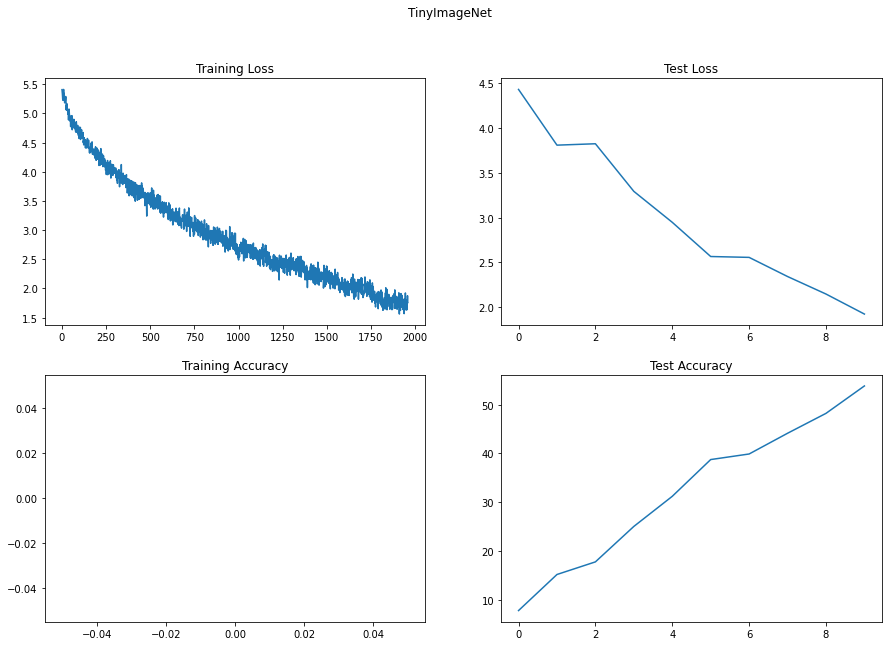

In [17]:
plot_single_run(title="TinyImageNet", train_losses=train_losses, test_losses=test_losses, train_acc=train_acc,test_acc=test_acc)